In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

from __future__ import print_function

from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 20

# Advanced kernel modeling

This notebook was made with the following version of george:

In [2]:
import george
george.__version__

'1.0.0.dev0'

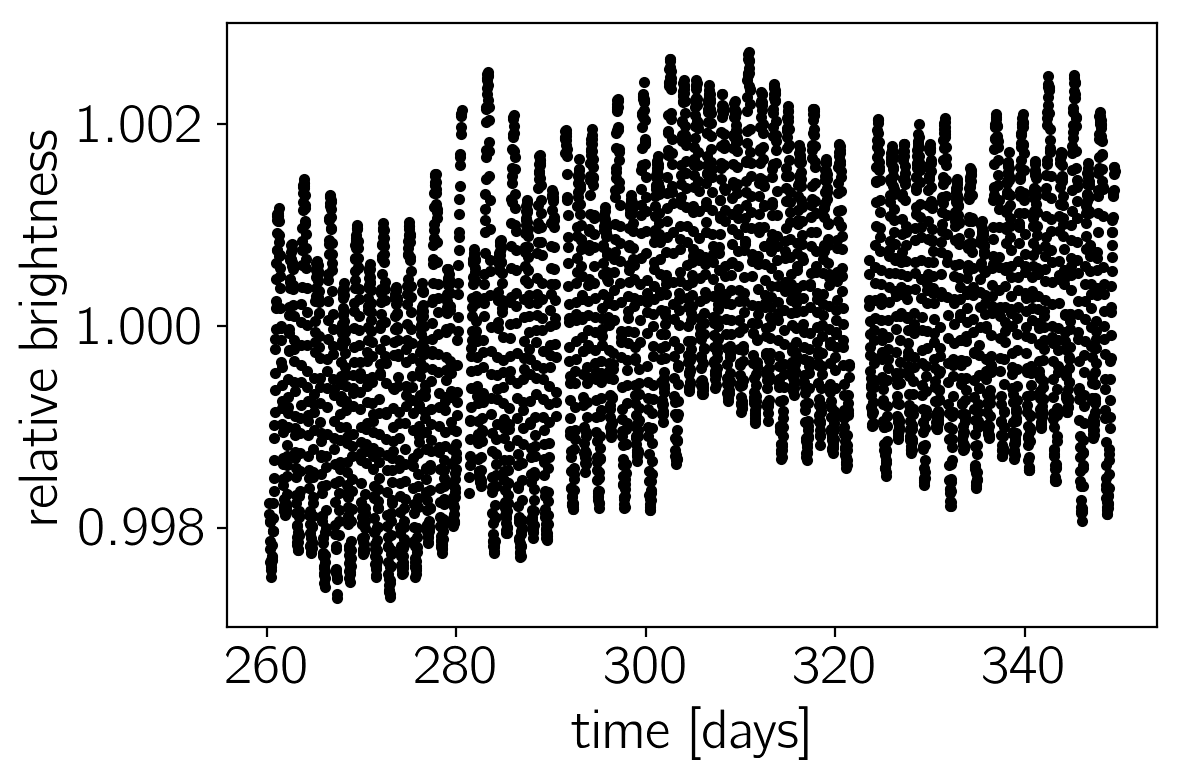

In [3]:
import kplr
import numpy as np
import matplotlib.pyplot as pl

client = kplr.API()
lc = client.light_curves(10295224, short_cadence=False, sci_data_quarter=3)[0]
data = lc.read()

x = data["TIME"]
y = data["SAP_FLUX"]
yerr = data["SAP_FLUX_ERR"]
mu = np.median(y[np.isfinite(y)])
y /= mu
yerr /= mu

pl.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
pl.xlabel("time [days]")
pl.ylabel("relative brightness");

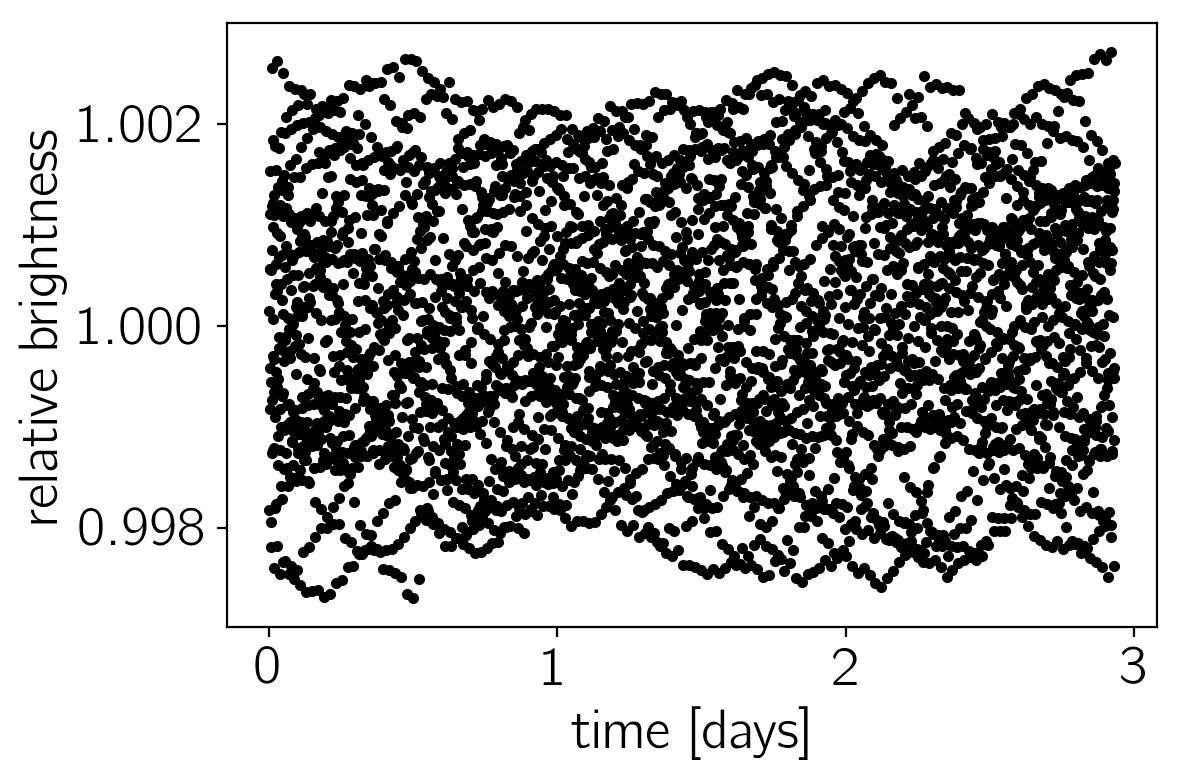

In [4]:
pl.errorbar(x % 2.9327280226002399, y, yerr=yerr, fmt=".k", capsize=0)
pl.xlabel("time [days]")
pl.ylabel("relative brightness");

In [5]:
from scipy.ndimage.measurements import label

sects, count = label(np.isfinite(x))
ranges = [(x[sects == s].min(), x[sects == s].max()) for s in range(1, count+1)]
ranges = [rng for rng in ranges if rng[1] > rng[0]]
print(ranges)

[(260.2250784075004, 290.54767162804637), (291.42628471651551, 321.44203856051899), (323.52618048039585, 349.49623066330241)]


In [6]:
m = np.isfinite(x) & np.isfinite(y) & np.isfinite(yerr)
x = x[m]
y = y[m]
yerr = yerr[m]

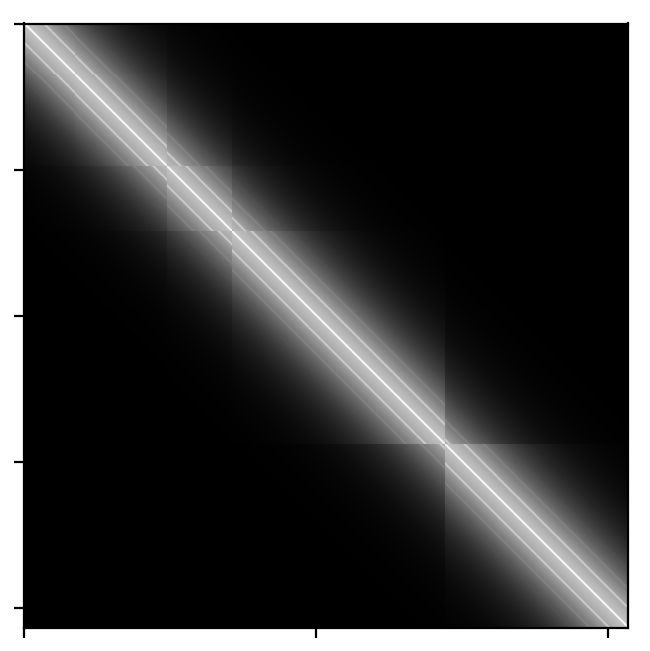

In [8]:
from george import kernels

kernel = np.var(y) * kernels.ExpSine2Kernel(log_period=np.log(2.75), gamma=18.0) * kernels.ExpSquaredKernel(10.)
for rng in ranges:
    kernel += np.var(y) * kernels.Matern32Kernel(50., bounds=[rng])
    
gp = george.GP(kernel, solver=george.HODLRSolver, mean=1.0)
gp.compute(x, yerr)

K = gp.get_matrix(x)
pl.imshow(K, cmap="gray", interpolation="nearest")
pl.gca().set_xticklabels([])
pl.gca().set_yticklabels([]);

In [9]:
names = gp.get_parameter_names()
[gp.freeze_parameter(n) for n in names[4:]]
gp.get_parameter_names()

('mean:value',
 'kernel:k1:k1:k1:k1:k1:log_constant',
 'kernel:k1:k1:k1:k1:k2:gamma',
 'kernel:k1:k1:k1:k1:k2:log_period')

In [10]:
def nll0(p):
    gp.set_parameter_vector(p)
    return -gp.log_likelihood(y, quiet=True)

def grad_nll0(p):
    gp.set_parameter_vector(p)
    return -gp.grad_log_likelihood(y, quiet=True)

In [11]:
print(nll0(gp.get_parameter_vector()))
print(grad_nll0(gp.get_parameter_vector()))

-26529.2007269
[-76.69780388  -5.10880303  -2.40937582  98.92317811]


In [13]:
from scipy.optimize import minimize
bounds = gp.get_parameter_bounds()
bounds[2] = (np.log(2.5), np.log(3.0))
result = minimize(nll0, gp.get_parameter_vector(), jac=grad_nll0, method="L-BFGS-B",
                  bounds=bounds)
print(result)

KeyboardInterrupt: 

In [ ]:
np.exp(result.x)

In [ ]:
gp.set_vector(result.x)

In [ ]:
K = gp.get_matrix(x)
pl.imshow(K, cmap="gray", interpolation="nearest")
pl.gca().set_xticklabels([])
pl.gca().set_yticklabels([]);

In [ ]:
mu = gp.predict(y, x, return_cov=False)

In [ ]:
pl.plot(x, y, ".k")
pl.plot(x, mu, "g")

In [17]:
map(gp.thaw_parameter, names)

[None, None, None, None, None, None, None, None, None, None]

In [18]:
gp.get_parameter_names()

['kernel:k1:k1:k1:k1:k1:ln_constant',
 'kernel:k1:k1:k1:k1:k2:gamma',
 'kernel:k1:k1:k1:k1:k2:ln_period',
 'kernel:k1:k1:k1:k2:ln_M_0_0',
 'kernel:k1:k1:k2:k1:ln_constant',
 'kernel:k1:k1:k2:k2:ln_M_0_0',
 'kernel:k1:k2:k1:ln_constant',
 'kernel:k1:k2:k2:ln_M_0_0',
 'kernel:k2:k1:ln_constant',
 'kernel:k2:k2:ln_M_0_0']

In [19]:
def update_gp_with_vector(p):
    vector = np.concatenate([p[:4]] + [p[4:] for _ in ranges])
    gp.set_vector(vector)

def nll(p):
    update_gp_with_vector(p)
    return -gp.lnlikelihood(y)

def grad_nll(p):
    update_gp_with_vector(p)
    grad = gp.grad_lnlikelihood(y)
    n = 6
    for _ in ranges[:-1]:
        grad[4:6] += grad[n:n+2]
        n += 2
    return -grad[:6]

In [20]:
nll(gp.get_vector()[:6])

-20745.569424230212

In [66]:
bounds = bounds[:4] + [(None, None), (2*np.log(3.0), None)]
result = minimize(nll, gp.get_vector()[:6], jac=grad_nll, method="L-BFGS-B",
                  bounds=bounds)

In [67]:
result

  status: 0
 success: True
    nfev: 23
     fun: -31701.465175322373
       x: array([-15.48532286,  29.49509814,   1.09861229,   6.35171531,
        -5.73608437,   2.19722458])
 message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     jac: array([  5.59920833e+03,   3.77054178e+02,  -4.20164665e+04,
         1.08358643e+02,   1.49932879e+01,  -2.16634231e+01])
     nit: 4

In [68]:
update_gp_with_vector(result.x)

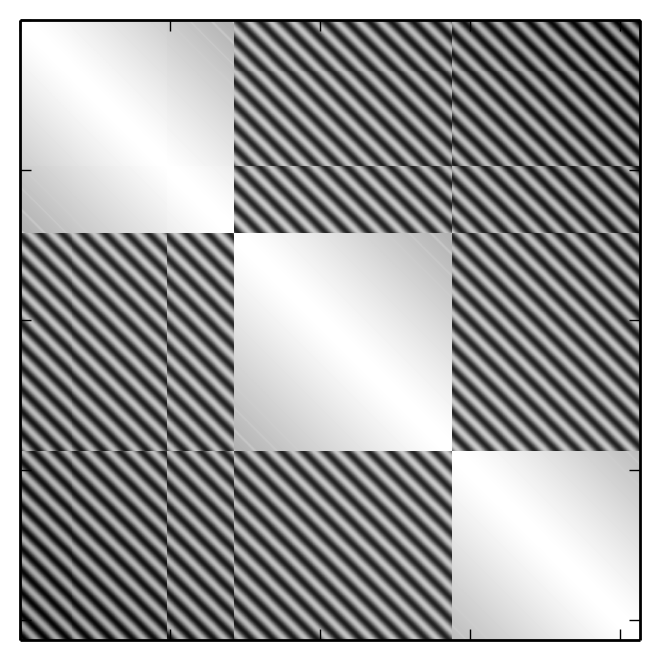

In [69]:
K = gp.get_matrix(x)
pl.imshow(np.log(K), cmap="gray", interpolation="nearest")
pl.gca().set_xticklabels([])
pl.gca().set_yticklabels([]);

In [70]:
gp.kernel

ConstantKernel(ln_constant=-15.4853228636, ndim=1, axes=[0]) * ExpSine2Kernel(gamma=29.4950981398, ln_period=1.09861228867, ndim=1, axes=[0]) * ExpSquaredKernel(metric=Metric(573.475555574, ndim=1, axes=[0])) + ConstantKernel(ln_constant=-5.73608437475, ndim=1, axes=[0]) * Matern32Kernel(metric=Metric(9.0, ndim=1, axes=[0])) + ConstantKernel(ln_constant=-5.73608437475, ndim=1, axes=[0]) * Matern32Kernel(metric=Metric(9.0, ndim=1, axes=[0])) + ConstantKernel(ln_constant=-5.73608437475, ndim=1, axes=[0]) * Matern32Kernel(metric=Metric(9.0, ndim=1, axes=[0]))

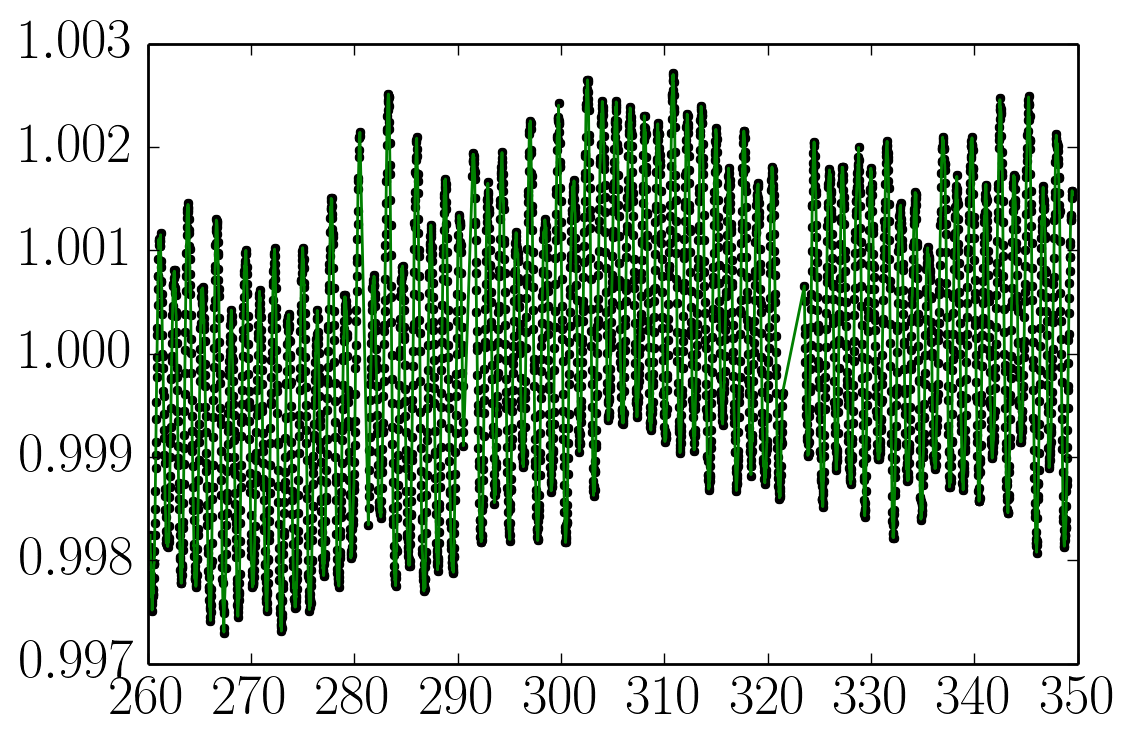

In [71]:
mu = gp.predict(y, x, return_cov=False)
pl.plot(x, y, ".k")
pl.plot(x, mu, "g")

In [73]:
K_0 = gp.get_matrix(x) - gp.kernel.k1.k1.k1.get_value(x[:, None])

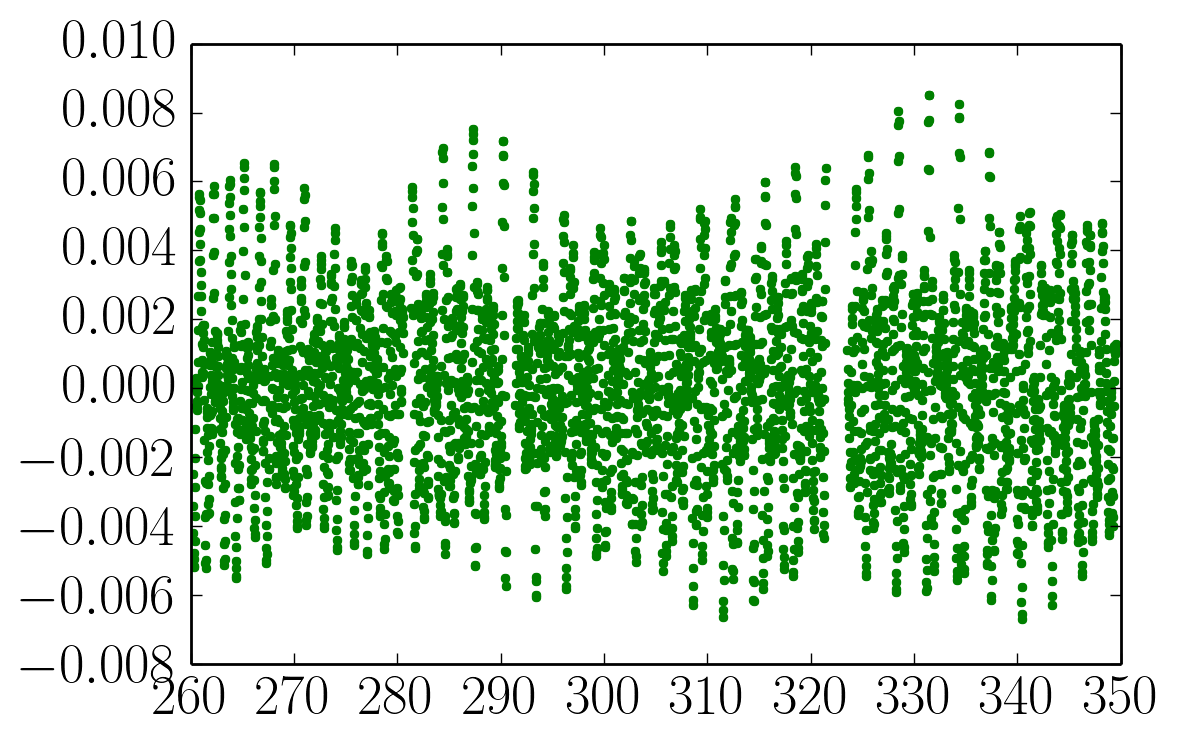

In [74]:
pred = np.dot(K_0, gp.apply_inverse(y)) + 1.0

pl.plot(x, y-pred, ".g")

In [75]:
period = np.exp(gp.kernel.k1.k1.k1.k1.k2.ln_period)

In [76]:
samp = gp.sample(x)

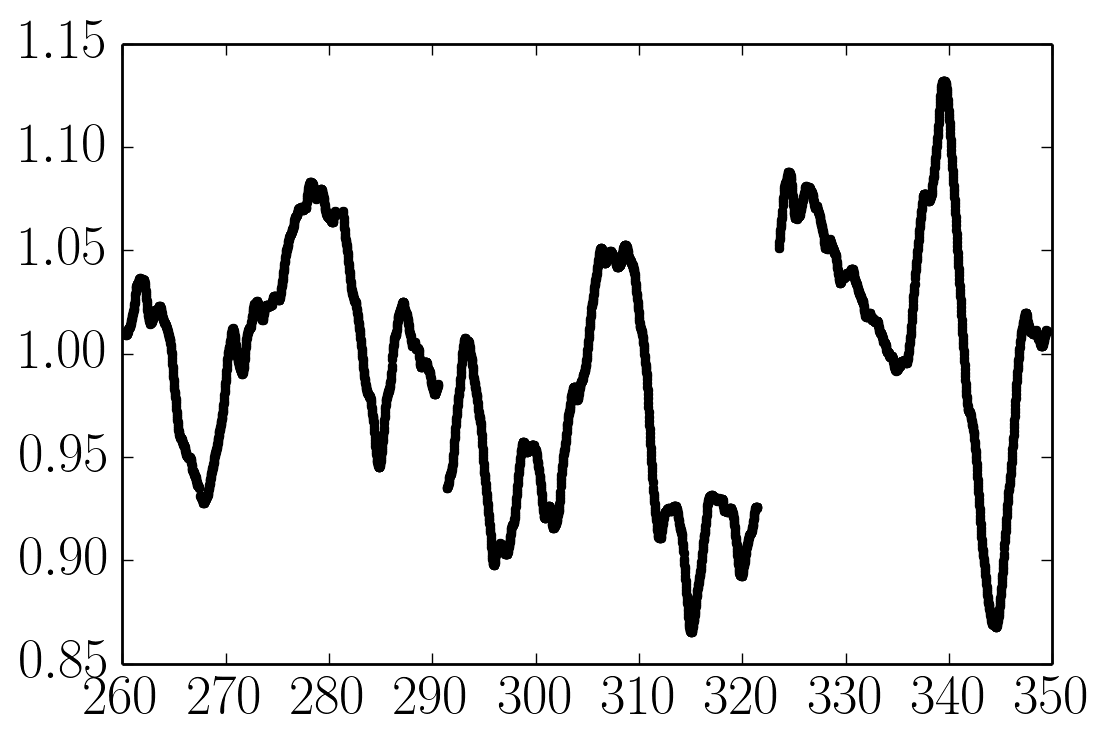

In [77]:
pl.plot(x, samp, ".k")

In [78]:
gp.get_parameter_names()

['kernel:k1:k1:k1:k1:k1:ln_constant',
 'kernel:k1:k1:k1:k1:k2:gamma',
 'kernel:k1:k1:k1:k1:k2:ln_period',
 'kernel:k1:k1:k1:k2:ln_M_0_0',
 'kernel:k1:k1:k2:k1:ln_constant',
 'kernel:k1:k1:k2:k2:ln_M_0_0',
 'kernel:k1:k2:k1:ln_constant',
 'kernel:k1:k2:k2:ln_M_0_0',
 'kernel:k2:k1:ln_constant',
 'kernel:k2:k2:ln_M_0_0']